In [320]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin

In [321]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels)

    E = (pdf*pdf.columns.values[np.newaxis, :] / pdf.sum(1).values[:, np.newaxis]).sum(1)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels)],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [322]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr']
n_voxels = [0, 1, 100]

pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv))

  0%|          | 0/315 [00:00<?, ?it/s]

In [323]:
pred = pd.concat(pred)
pdf = pd.concat(pdfs)

In [324]:
df = get_all_behavior(drop_no_responses=False)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:66: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:41: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)


In [325]:
pred = pred.join(df, how='inner')

In [326]:
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_21616/2590181517.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [327]:
import seaborn as sns

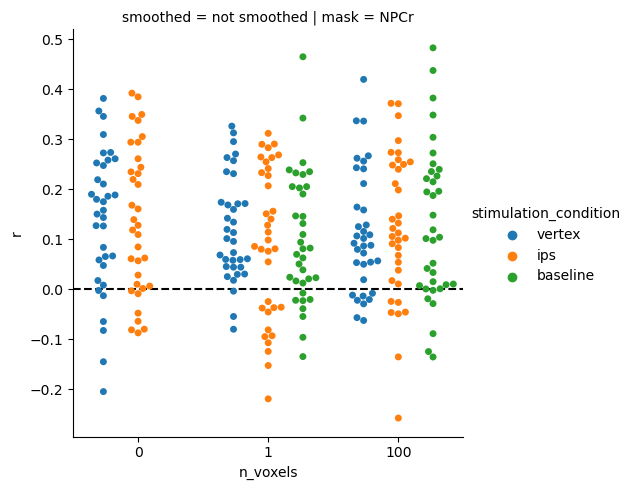

In [328]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)
plt.axhline(0, c='k', ls='--')

In [329]:
r2

n  \
subject session stimulation_condition pca    glm     smoothed     mask n_voxels         
1       1       baseline              no pca GLMstim not smoothed NPCr 1         20.0   
                                                                       100       20.0   
        2       vertex                no pca GLMstim not smoothed NPCr 0         20.0   
                                                                       1         20.0   
                                                                       100       20.0   
...                                                                               ...   
74      2       ips                   no pca GLMstim not smoothed NPCr 1         20.0   
                                                                       100       20.0   
        3       vertex                no pca GLMstim not smoothed NPCr 0         20.0   
                                                                       1         20.0   
                                                                       100       20.0   

                                                                                        r  \
subject session stimulation_condition pca    glm     smoothed     mask n_voxels             
1       1       baseline              no pca GLMstim not smoothed NPCr 1        -0.007642   
                                                                       100       0.272638   
        2       vertex                no pca GLMstim not smoothed NPCr 0         0.083855   
                                                                       1         0.059756   
                                                                       100       0.086659   
...                                                                                   ...   
74      2       ips                   no pca GLMstim not smoothed NPCr 1         0.085736   
                                                                       100       0.112734   
        3       vertex                no pca GLMstim not smoothed NPCr 0         0.252744   
                                                                       1         0.134355   
                                                                       100       0.262224   

                                                                                    p-val  \
subject session stimulation_condition pca    glm     smoothed     mask n_voxels             
1       1       baseline              no pca GLMstim not smoothed NPCr 1         0.528435   
                                                                       100       0.350605   
        2       vertex                no pca GLMstim not smoothed NPCr 0         0.507506   
                                                                       1         0.432038   
                                                                       100       0.517393   
...                                                                                   ...   
74      2       ips                   no pca GLMstim not smoothed NPCr 1         0.653165   
                                                                       100       0.543854   
        3       vertex                no pca GLMstim not smoothed NPCr 0         0.338418   
                                                                       1         0.433969   
                                                                       100       0.375017   

                                                                                    power  
subject session stimulation_condition pca    glm     smoothed     mask n_voxels            
1       1       baseline              no pca GLMstim not smoothed NPCr 1         0.137821  
                                                                       100       0.311258  
        2       vertex                no pca GLMstim not smoothed NPCr 0         0.202990  
                                              

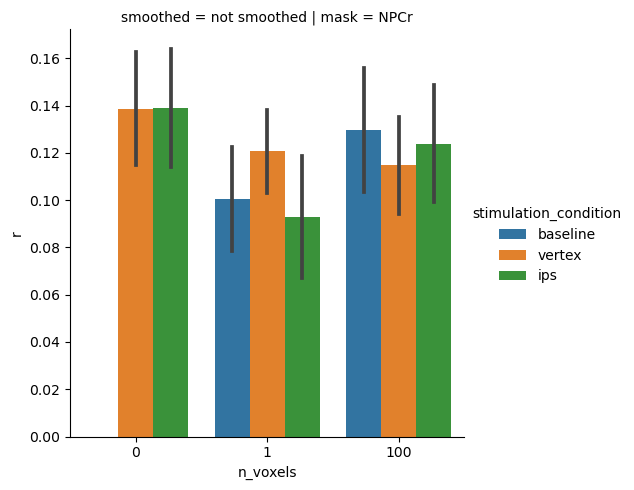

In [330]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, errorbar='se')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_21616/1125108059.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_pars = pred.groupby(['subject', 'stimulation_condition', 'n_voxels']).mean()


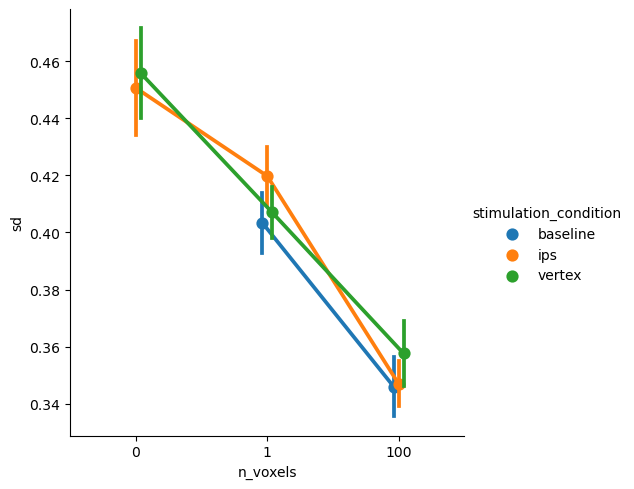

In [331]:
mean_pars = pred.groupby(['subject', 'stimulation_condition', 'n_voxels']).mean()

sns.catplot(mean_pars.reset_index(), x='n_voxels', y='sd', hue='stimulation_condition', kind='point', errorbar='se', dodge=True)

In [332]:
tmp = r2.xs(1, 0, 'n_voxels').drop(1, level='session')


pingouin.rm_anova(tmp.reset_index(), 'r', within='stimulation_condition', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,0.871226,0.357198,0.011499,1.0


In [333]:
tmp.droplevel('stimulation_condition').unstack('session')['r']

,,,,session,2,3
subject,pca,glm,smoothed,mask,,
1,no pca,GLMstim,not smoothed,NPCr,0.059756,0.140501
2,no pca,GLMstim,not smoothed,NPCr,0.068515,-0.107119
3,no pca,GLMstim,not smoothed,NPCr,0.030443,-0.036803
4,no pca,GLMstim,not smoothed,NPCr,0.254865,-0.054456
5,no pca,GLMstim,not smoothed,NPCr,0.168624,0.128212
6,no pca,GLMstim,not smoothed,NPCr,0.263467,0.119813
7,no pca,GLMstim,not smoothed,NPCr,0.268842,0.044185
9,no pca,GLMstim,not smoothed,NPCr,-0.093007,0.060973
10,no pca,GLMstim,not smoothed,NPCr,-0.024621,0.159757


In [334]:
tmp = r2.xs(100, 0, 'n_voxels').drop(1, level='session')


pingouin.rm_anova(tmp.reset_index(), 'r', within='stimulation_condition', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,0.091427,0.764214,0.001207,1.0


In [335]:
mean_pars

E        sd        rt  \
subject stimulation_condition n_voxels                                 
1       baseline              1         3.201637  0.360536  1.206715   
                              100       3.180473  0.345199  1.206715   
        ips                   0         3.159833  0.312337  1.421095   
                              1         3.238782  0.345732  1.421095   
                              100       3.219130  0.316473  1.421095   
...                                          ...       ...       ...   
74      ips                   1         3.273181  0.424957  0.641388   
                              100       3.114238  0.302180  0.641388   
        vertex                0         3.105914  0.331382  0.681777   
                              1         3.163584  0.363438  0.681777   
                              100       3.131432  0.256965  0.681777   

                                               n1         n2     p1     p2  \
subject stimulation_condition n_voxels                                       
1       baseline              1         26.466667  26.466667  0.775  0.775   
                              100       26.466667  26.466667  0.775  0.775   
        ips                   0         26.466667  26.466667  0.775  0.775   
                              1         26.466667  26.466667  0.775  0.775   
                              100       26.466667  26.466667  0.775  0.775   
...                                           ...        ...    ...    ...   
74      ips                   1         25.983333  25.983333  0.775  0.775   
                              100       25.983333  25.983333  0.775  0.775   
        vertex                0         25.983333  25.983333  0.775  0.775   
                              1         25.983333  25.983333  0.775  0.775   
                              100       25.983333  25.983333  0.775  0.775   

                                          choice  risky_first    n_risky  \
subject stimulation_condition n_voxels                                     
1       baseline              1         1.483333          0.5  37.133333   
                              100       1.483333          0.5  37.133333   
        ips                   0         1.541667          0.5  37.133333   
                              1         1.541667          0.5  37.133333   
                              100       1.541667          0.5  37.133333   
...                                          ...          ...        ...   
74      ips                   1         1.433333          0.5  36.166667   
                              100       1.433333          0.5  36.166667   
        vertex                0         1.458333          0.5  36.166667   
                              1         1.458333          0.5  36.166667   
                              100       1.458333          0.5  36.166667   

                                        n_safe      frac  log(risky/safe)  \
subject stimulation_condition n_voxels                                      
1       baseline              1           15.8  2.339762         0.831188   
                              100         15.8  2.339762         0.831188   
        ips                   0           15.8  2.339762         0.831188   
                              1           15.8  2.339762         0.831188   
                              100         15.8  2.339762         0.831188   
...                                        ...       ...              ...   
74      ips                   1           15.8  2.278810         0.729799   
                              100         15.8  2.278810         0.729799   
        vertex                0           15.8  2.278810         0.729799   
                              1           15.8  2.278810         0.729799   
                              100         15.8  2.278810         0.729799   

                                         log(n1)  
subject stimulation_condition n_voxels            
1 

In [336]:
,e

NameError: name 'e' is not defined

In [ ]:
pingouin.rm_anova(mean_pars.drop('baseline', level='stimulation_condition').xs(0, 0, 'n_voxels').reset_index(), 'sd', within='stimulation_condition', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,0.143096,0.707574,0.000755,1.0


In [ ]:
pingouin.rm_anova(mean_pars.drop('baseline', level='stimulation_condition').xs(100, 0, 'n_voxels').reset_index(), 'sd', within='stimulation_condition', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,0.556886,0.460647,0.00859,1.0


In [ ]:
np.exp(0.45)

1.568312185490169